In [35]:
import PyPDF2
import nltk
import spacy
#nltk.download('stopwords')
from nltk.corpus import stopwords
import string
import re

In [37]:
# relevant functions
def extract_text_from_pdf(pdf_path):
    """
    This function extracts text from a pdf doc into a single stream of text.
    """
    text = ""
    with open(pdf_path, "rb") as pdf_file:
        pdf_reader = PyPDF2.PdfReader(pdf_file)
        for page_num in range(len(pdf_reader.pages)):
            page = pdf_reader.pages[page_num]
            text += page.extract_text()
    return text

def preprocess_text(text: str):
    """
    This function pre-processes the text into a useful format for ML algorithms.
    """
    singles_removed = re.sub(r'\s+[a-zA-Z]\s', ' ', text) # remove single characters
    tokens = nltk.word_tokenize(singles_removed) # text tokenisation
    clean_tokens = [token.lower() for token in tokens if token.isalnum()] # remove non-alphanumeric tokens + lowercase
    stop_all = stopwords.words('english') + list(string.punctuation) # define stopwords
    stop_removal = [stop for stop in clean_tokens if stop not in stop_all] # remove stopwords
    
    pos_tokens = nltk.pos_tag(clean_tokens)
    return stop_removal#, pos_tokens

def word_frequency_dist(tokens: list):
    """This function shows the frequency distribution of the top 30 most common words in the text."""
    fdist = nltk.FreqDist(tokens)
    return fdist.plot(30, cumulative = False)


In [38]:
SNOW = extract_text_from_pdf("Data/SNOW_Q224.pdf")
tokens = preprocess_text(SNOW)

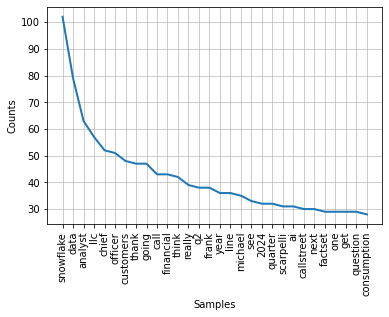

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [39]:
word_frequency_dist(tokens)